In [1]:
# import data science libraries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from datetime import datetime

from sklearn.metrics import mean_squared_error

from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import wrangle as wr
import preprocessing as pr

In [2]:
# global setting for DataFrames and visualizations
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))
sns.set_palette("colorblind")

In [3]:
import fbprophet
fbprophet.__version__

'0.6'

# Wrangle

In [4]:
df = wr.wrangle_saas_data()
print(f"The saas DataFrame is made up of {df.shape[0]:,} rows {df.shape[1]} columns.")
df

The saas DataFrame is made up of 790,458 rows 4 columns.


,customer_id,invoice_id,subscription_type,amount
invoice_month,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0
2014-01-31,1013334,5013334,0.0,0.0
2014-01-31,1013333,5013333,1.0,5.0
...,...,...,...,...
2017-12-31,1012069,5781185,0.0,0.0
2017-12-31,1012072,5781186,0.0,0.0
2017-12-31,1012074,5781187,1.0,5.0


In [5]:
df.isna().sum()

customer_id          0
invoice_id           0
subscription_type    0
amount               0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        790458 non-null  int64  
 1   invoice_id         790458 non-null  int64  
 2   subscription_type  790458 non-null  float64
 3   amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


---
# Preprocessing

In [7]:
train, test = pr.split_saas_data(df)
print(f"The saas DataFrame is made up of {train.shape[0]:,} rows {train.shape[1]} columns.")
train

The saas DataFrame is made up of 618,169 rows 4 columns.


,customer_id,invoice_id,subscription_type,amount
invoice_month,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0
2014-01-31,1013334,5013334,0.0,0.0
2014-01-31,1013333,5013333,1.0,5.0
...,...,...,...,...
2016-12-31,1010259,5608214,3.0,15.0
2016-12-31,1010228,5608206,0.0,0.0
2016-12-31,1010199,5608193,1.0,5.0


In [8]:
train.shape[0] / df.shape[0]

0.782039020416012

In [9]:
train

,customer_id,invoice_id,subscription_type,amount
invoice_month,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0
2014-01-31,1013334,5013334,0.0,0.0
2014-01-31,1013333,5013333,1.0,5.0
...,...,...,...,...
2016-12-31,1010259,5608214,3.0,15.0
2016-12-31,1010228,5608206,0.0,0.0
2016-12-31,1010199,5608193,1.0,5.0


In [10]:
print((train.shape[0] + test.shape[0]) == df.shape[0])
print(train.head(1) == df.head(1))
print(test.tail(1) == df.tail(1))

True
               customer_id  invoice_id  subscription_type  amount
invoice_month                                                    
2014-01-31            True        True               True    True
               customer_id  invoice_id  subscription_type  amount
invoice_month                                                    
2017-12-31            True        True               True    True


In [11]:
train = pd.DataFrame(train.resample("M").amount.sum())
train

,amount
invoice_month,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [12]:
test = pd.DataFrame(test.resample("M").amount.sum())
test

,amount
invoice_month,
2017-01-31,53395.0
2017-02-28,53440.0
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0
2017-08-31,53820.0
2017-09-30,53925.0


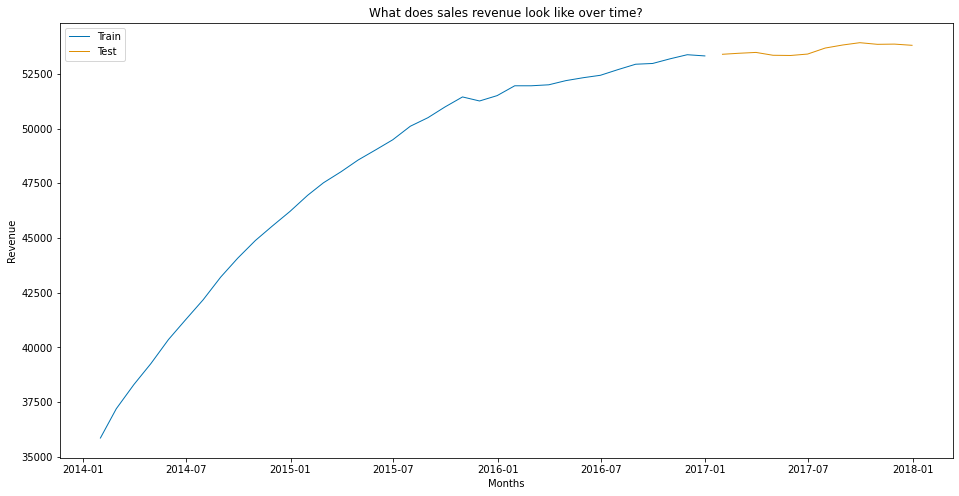

In [13]:
# plot the train and test DataFrameslp = train.plot(figsize=(16, 8))
plt.plot(train.amount, label="Train", linewidth=1)
plt.plot(test.amount, label="Test", linewidth=1)

# labels
plt.title("What does sales revenue look like over time?")
plt.xlabel("Months")
plt.ylabel("Revenue")
plt.legend()
plt.show()

---
# EDA

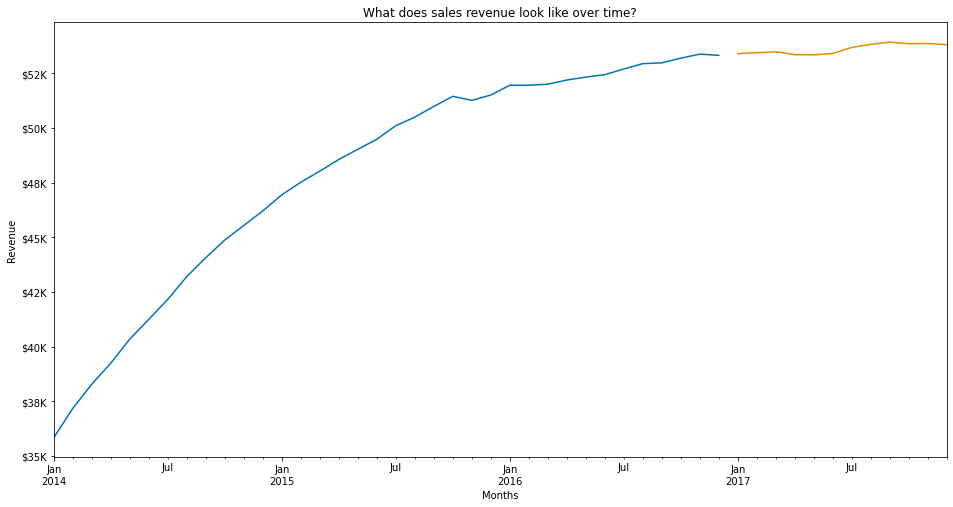

In [14]:
# plot the train and test DataFrames
lp = train.amount.plot(figsize=(16, 8))
test.amount.plot(figsize=(16, 8))

# divide amount values by 1000 for better xticks
ylabels = ["${:.0f}".format(x) + "K" for x in lp.get_yticks() / 1000]
lp.set_yticklabels(ylabels)

# labels
plt.title("What does sales revenue look like over time?")
plt.xlabel("Months")
plt.ylabel("Revenue")
plt.show()

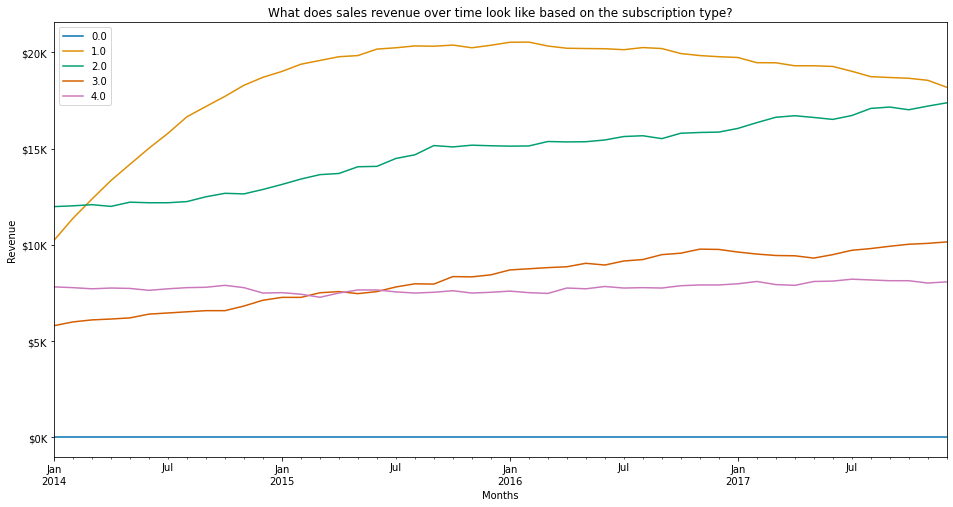

In [15]:
# what does volume look like based on the subscription type?
for sub in df.subscription_type.sort_values().unique().tolist():
    ax = df[df.subscription_type == sub].groupby("invoice_month").amount.sum().plot(figsize=(16,8))
    
    # divide amount values by 1000 for better xticks
    ylabels = ["${:.0f}".format(x) + "K" for x in ax.get_yticks() / 1000]
    ax.set_yticklabels(ylabels)

# labels
plt.title("What does sales revenue over time look like based on the subscription type?")
plt.xlabel("Months")
plt.ylabel("Revenue")
plt.legend(df.subscription_type.sort_values().unique().tolist())
plt.show()

**Takeaways**: Looks like subscription type `0.0` may be prospects? Regardless, there is no revenue coming in from type `0.0`. Type `1.0` seems to have seen a decline in popularity as of late despite a rather meteoric rise in popularity from 2014 through mid-2015. Subscription types `2.0` and `3.0` have seen steady growth for the time period observed in the data set; howvever, type `3.0`'s revenue is lower than `2.0`. I'd like to know the COGS for each subscription type in order to determine which product line is most profitable. Type `4.0` has seen the same amount of revenue throughout the observed time period.

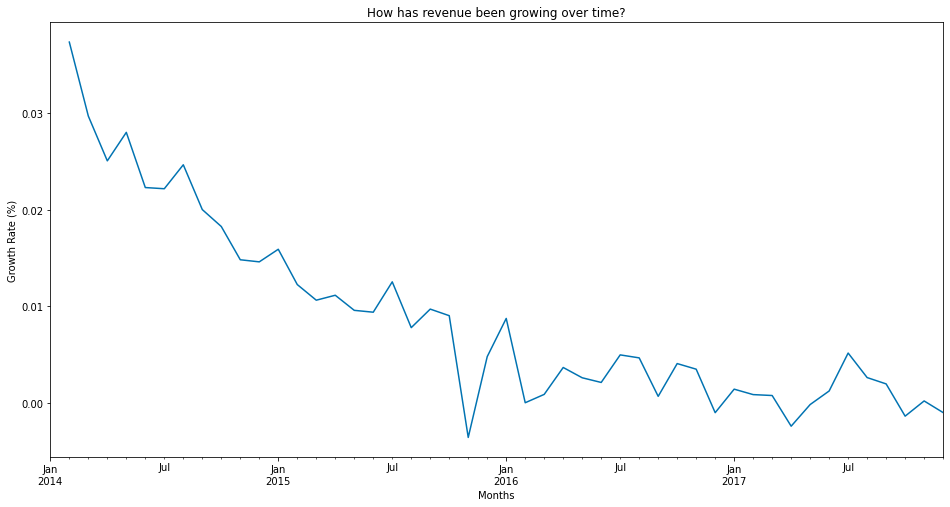

In [16]:
# what does the overall growth rate for all subscriptions look like?
df.groupby("invoice_month").amount.sum().pct_change().plot(figsize=(16, 8))

# labels
plt.title("How has revenue been growing over time?")
plt.xlabel("Months")
plt.ylabel("Growth Rate (%)")
plt.show()

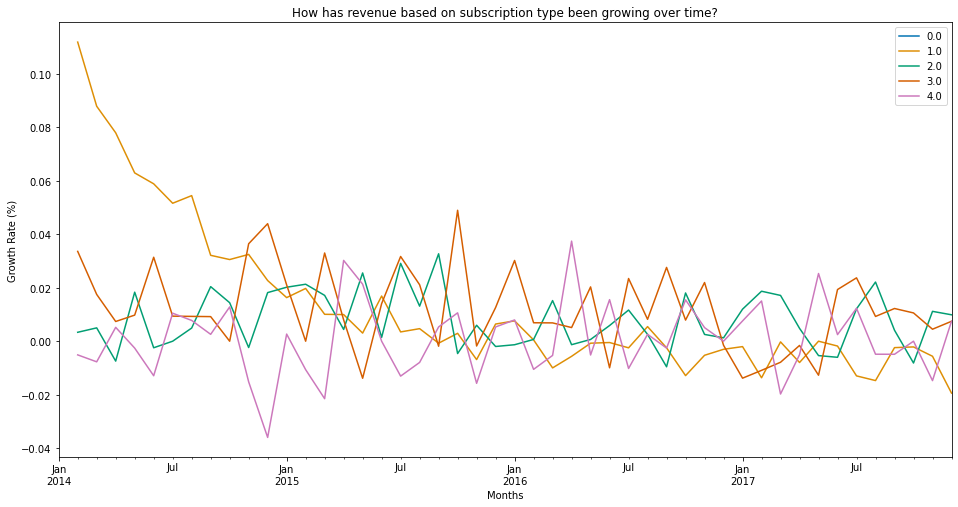

In [17]:
# what do growth rates look like based on the subscription type?
for sub in df.subscription_type.sort_values().unique().tolist():
    ax = df[df.subscription_type == sub].groupby("invoice_month").amount.sum().pct_change().plot(figsize=(16,8))
    
# labels
plt.title("How has revenue based on subscription type been growing over time?")
plt.xlabel("Months")
plt.ylabel("Growth Rate (%)")
plt.legend(df.subscription_type.sort_values().unique().tolist())
plt.show()

**Takeaway**: This is not good. There has been a steady decline in growth for the data throughout the time period. If this is not already known, this needs to be communicated ASAP.

---
# Forecasting (Modeling)
## Last Observed Value
### Predict

In [18]:
train.amount[-1]

53320.0

In [19]:
# amount
amount = round(train.amount[-1], 2)

# predictions DataFrame
yhat_df = pd.DataFrame(
    {
    "amount": [amount]
    },
    index = test.index
)

yhat_df

,amount
invoice_month,
2017-01-31,53320.0
2017-02-28,53320.0
2017-03-31,53320.0
2017-04-30,53320.0
2017-05-31,53320.0
2017-06-30,53320.0
2017-07-31,53320.0
2017-08-31,53320.0
2017-09-30,53320.0


### Evaluate

In [20]:
print("amount rmse =", round(sqrt(mean_squared_error(test["amount"], yhat_df["amount"])), 0))

amount rmse = 366.0


**Note**: Let's make a DataFrame to store our evaluation metrics.

In [21]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

**Note**: Let's make a few functions to help us with forecasting and evaluation.

In [22]:
# evaluation function to compute rmse
def evaluate():
    """
    This function evaluates our forecast using the root mean square error as compared to the out-of-sample data in our test DataFrame.
    """
    
    # compute rmse
    rmse = round(sqrt(mean_squared_error(test["amount"], yhat_df["amount"])), 0)
    
    return rmse

In [23]:
evaluate()

366.0

### Plot Actual vs. Predicted Values

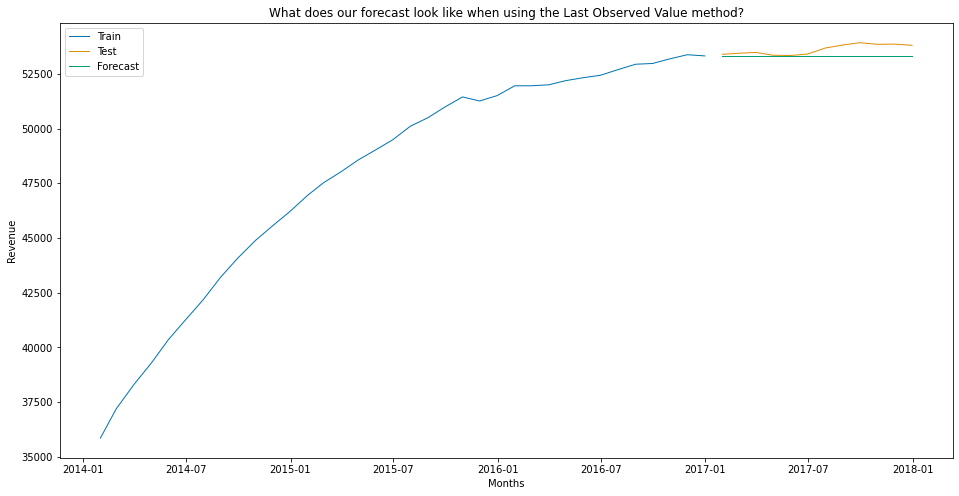

In [24]:
plt.plot(train.amount, label="Train", linewidth=1)
plt.plot(test.amount, label="Test", linewidth=1)
plt.plot(yhat_df.amount, label="Forecast", linewidth=1)

# labels
plt.title("What does our forecast look like when using the Last Observed Value method?")
plt.xlabel("Months")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [25]:
def plot_and_eval(model):
    
    rmse = evaluate()
    print(f"amount rmse = {rmse}")
    
    plt.plot(train.amount, label="Train", linewidth=1)
    plt.plot(test.amount, label="Test", linewidth=1)
    plt.plot(yhat_df.amount, label=model, linewidth=1)

    # labels
    plt.title(f"What does our forecast look like when using the {model} method?")
    plt.xlabel("Months")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

amount rmse = 366.0


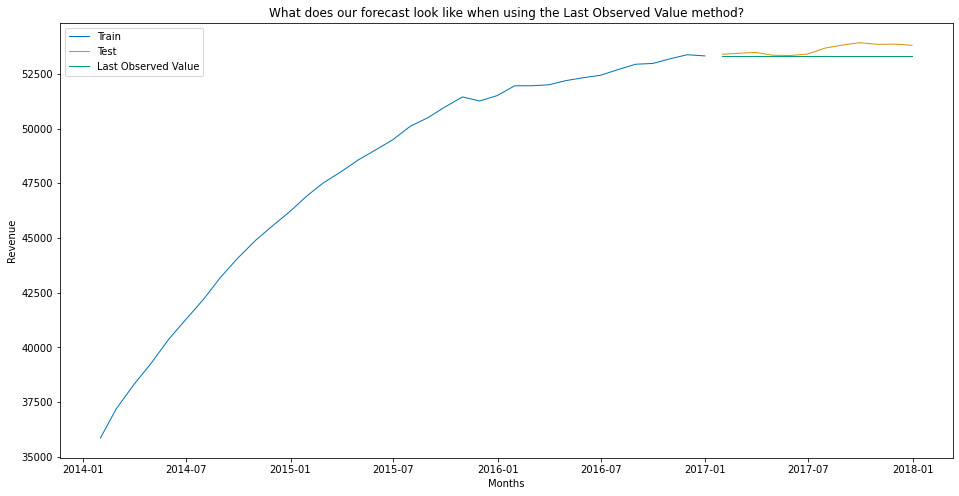

In [26]:
plot_and_eval(model="Last Observed Value")

### Append Evaluation Metrics

In [27]:
eval_df.head()

,model_type,target_var,rmse


In [28]:
def append_eval_df(model_type):
    
    # call evaluate function
    rmse = evaluate()
    
    # create dictionary of data
    data = pd.DataFrame({"model_type": [model_type], "target_var": "amount", "rmse": [rmse]})

    return eval_df.append(data, ignore_index = True)

In [29]:
eval_df = append_eval_df(model_type="Last Observed Value")
eval_df

,model_type,target_var,rmse
0,Last Observed Value,amount,366.0


---
## Simple Average
### Predict

In [30]:
train.amount.mean()

47916.666666666664

In [31]:
amount = round(train.amount.mean(), 2)

def make_predictions():
    
    yhat_df = pd.DataFrame({"amount": [amount],
                           }, index = test.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df

,amount
invoice_month,
2017-01-31,47916.67
2017-02-28,47916.67
2017-03-31,47916.67
2017-04-30,47916.67
2017-05-31,47916.67
2017-06-30,47916.67
2017-07-31,47916.67
2017-08-31,47916.67
2017-09-30,47916.67


### Evaluate

In [32]:
print(f"simple average amount rmse = {evaluate()}")

simple average amount rmse = 5700.0


### Plot Actual vs. Predicted Values

amount rmse = 5700.0


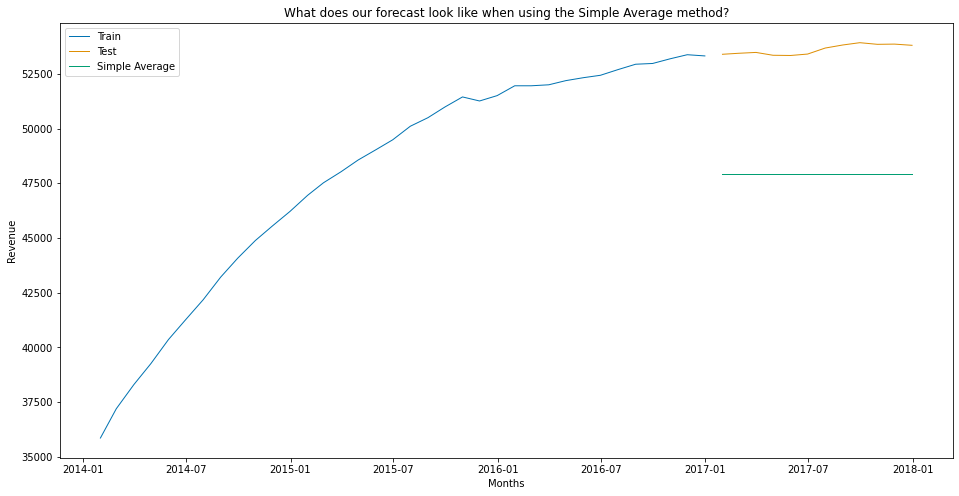

In [33]:
plot_and_eval(model="Simple Average")

### Append Evaluation Metrics

In [34]:
eval_df = append_eval_df(model_type="Simple Average")
eval_df

,model_type,target_var,rmse
0,Last Observed Value,amount,366.0
1,Simple Average,amount,5700.0


---
## Moving Average
### Predict

In [35]:
train.amount.rolling(6).mean()

invoice_month
2014-01-31             NaN
2014-02-28             NaN
2014-03-31             NaN
2014-04-30             NaN
2014-05-31             NaN
2014-06-30    38700.000000
2014-07-31    39753.333333
2014-08-31    40756.666667
2014-09-30    41720.000000
2014-10-31    42657.500000
2014-11-30    43522.500000
2014-12-31    44348.333333
2015-01-31    45144.166667
2015-02-28    45862.500000
2015-03-31    46520.833333
2015-04-30    47134.166667
2015-05-31    47714.166667
2015-06-30    48260.000000
2015-07-31    48786.666667
2015-08-31    49282.500000
2015-09-30    49775.833333
2015-10-31    50256.666667
2015-11-30    50629.166667
2015-12-31    50965.833333
2016-01-31    51274.166667
2016-02-29    51517.500000
2016-03-31    51686.666667
2016-04-30    51810.833333
2016-05-31    51988.333333
2016-06-30    52143.333333
2016-07-31    52266.666667
2016-08-31    52430.833333
2016-09-30    52593.333333
2016-10-31    52760.000000
2016-11-30    52935.000000
2016-12-31    53082.500000
Freq: M, Name:

In [36]:
train[:"2014-06-30"].amount.mean()

38700.0

In [37]:
train["2014-02-28":"2014-07-31"].amount.mean()

39753.333333333336

In [38]:
train["2016-07-31":].amount.mean()

53082.5

In [39]:
# compute a six month rolling average, 
# use the most recent/last 6 month period value to predict forward. 

period = 6

amount = round(train.amount.rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df

,amount
invoice_month,
2017-01-31,53082.5
2017-02-28,53082.5
2017-03-31,53082.5
2017-04-30,53082.5
2017-05-31,53082.5
2017-06-30,53082.5
2017-07-31,53082.5
2017-08-31,53082.5
2017-09-30,53082.5


### Evaluate

In [40]:
print(f"6M moving average amount rmse = {evaluate()}")

6M moving average amount rmse = 574.0


### Plot Actual vs. Predicted Values

amount rmse = 574.0


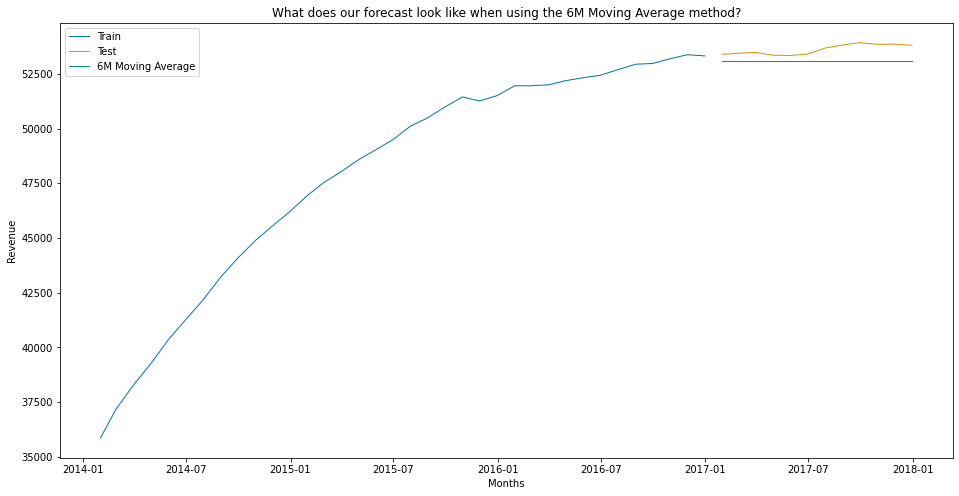

In [41]:
plot_and_eval(model="6M Moving Average")

### Append Evaluation Metrics

In [42]:
eval_df = append_eval_df(model_type="6M Moving Average")
eval_df

,model_type,target_var,rmse
0,Last Observed Value,amount,366.0
1,Simple Average,amount,5700.0
2,6M Moving Average,amount,574.0


In [43]:
periods = [3, 9, 12, 24]

for p in periods:
    amount = round(train.resample("M").amount.sum().rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type=model_type)

In [44]:
eval_df

,model_type,target_var,rmse
0,Last Observed Value,amount,366.0
1,Simple Average,amount,5700.0
2,6M Moving Average,amount,574.0
3,3M moving average,amount,386.0
4,9M moving average,amount,816.0
5,12M moving average,amount,1024.0
6,24M moving average,amount,2509.0


## Holt's Linear Trend
### Seasonal Decomposition

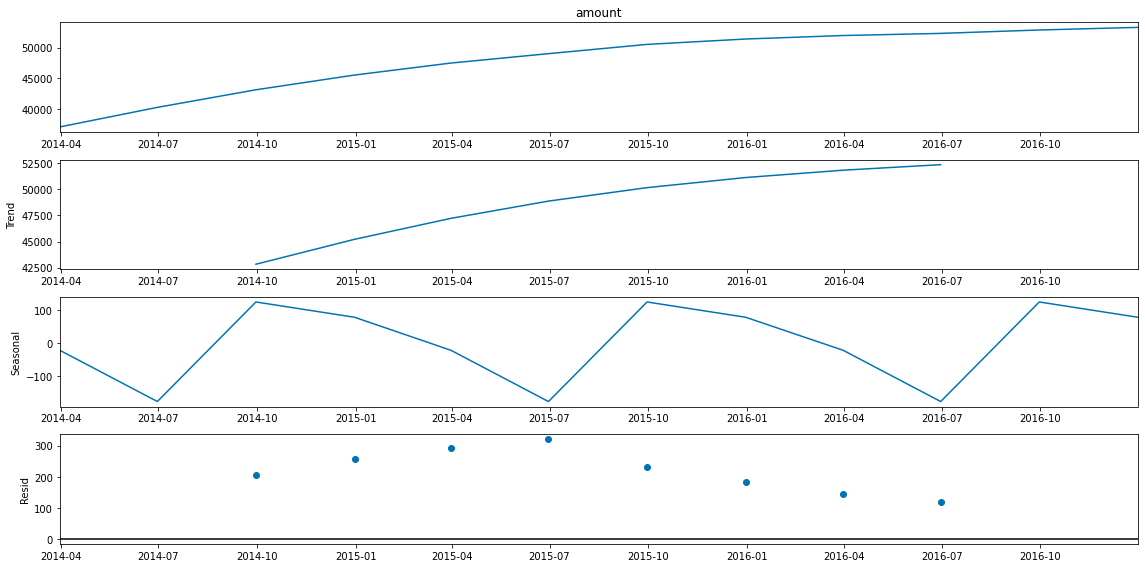

In [45]:
sm.tsa.seasonal_decompose(train.resample("Q").amount.mean()).plot()
plt.show()

### Predictions

In [46]:
test.index[0], test.index[-1]

(Timestamp('2017-01-31 00:00:00', freq='M'),
 Timestamp('2017-12-31 00:00:00', freq='M'))

In [47]:
test.index[0]

Timestamp('2017-01-31 00:00:00', freq='M')

In [48]:
train.amount

invoice_month
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
2014-06-30    41255.0
2014-07-31    42170.0
2014-08-31    43210.0
2014-09-30    44075.0
2014-10-31    44880.0
2014-11-30    45545.0
2014-12-31    46210.0
2015-01-31    46945.0
2015-02-28    47520.0
2015-03-31    48025.0
2015-04-30    48560.0
2015-05-31    49025.0
2015-06-30    49485.0
2015-07-31    50105.0
2015-08-31    50495.0
2015-09-30    50985.0
2015-10-31    51445.0
2015-11-30    51260.0
2015-12-31    51505.0
2016-01-31    51955.0
2016-02-29    51955.0
2016-03-31    52000.0
2016-04-30    52190.0
2016-05-31    52325.0
2016-06-30    52435.0
2016-07-31    52695.0
2016-08-31    52940.0
2016-09-30    52975.0
2016-10-31    53190.0
2016-11-30    53375.0
2016-12-31    53320.0
Freq: M, Name: amount, dtype: float64

In [49]:
test.index

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='invoice_month', freq='M')

In [50]:
model = Holt(train.amount, exponential=True)
model = model.fit(smoothing_level=.5, smoothing_slope=.3, optimized=False)
yhat_items = model.predict(start=test.index[0], end=test.index[-1])
yhat_df["amount"] = round(yhat_items, 2)
yhat_df

,amount
invoice_month,
2017-01-31,53559.60
2017-02-28,53697.56
2017-03-31,53835.87
2017-04-30,53974.53
2017-05-31,54113.55
2017-06-30,54252.93
2017-07-31,54392.67
2017-08-31,54532.77
2017-09-30,54673.23


### Evaluate

In [51]:
test["amount"]

invoice_month
2017-01-31    53395.0
2017-02-28    53440.0
2017-03-31    53480.0
2017-04-30    53350.0
2017-05-31    53340.0
2017-06-30    53405.0
2017-07-31    53680.0
2017-08-31    53820.0
2017-09-30    53925.0
2017-10-31    53850.0
2017-11-30    53860.0
2017-12-31    53805.0
Freq: M, Name: amount, dtype: float64

In [52]:
yhat_df.amount

invoice_month
2017-01-31    53559.60
2017-02-28    53697.56
2017-03-31    53835.87
2017-04-30    53974.53
2017-05-31    54113.55
2017-06-30    54252.93
2017-07-31    54392.67
2017-08-31    54532.77
2017-09-30    54673.23
2017-10-31    54814.06
2017-11-30    54955.24
2017-12-31    55096.79
Freq: M, Name: amount, dtype: float64

In [53]:
print(f"Holt's Linear Trend amount rmse = {round(sqrt(mean_squared_error(test.amount, yhat_df.amount)), 0)}")

Holt's Linear Trend amount rmse = 780.0


### Plot Actual vs. Predicted Values

amount rmse = 780.0


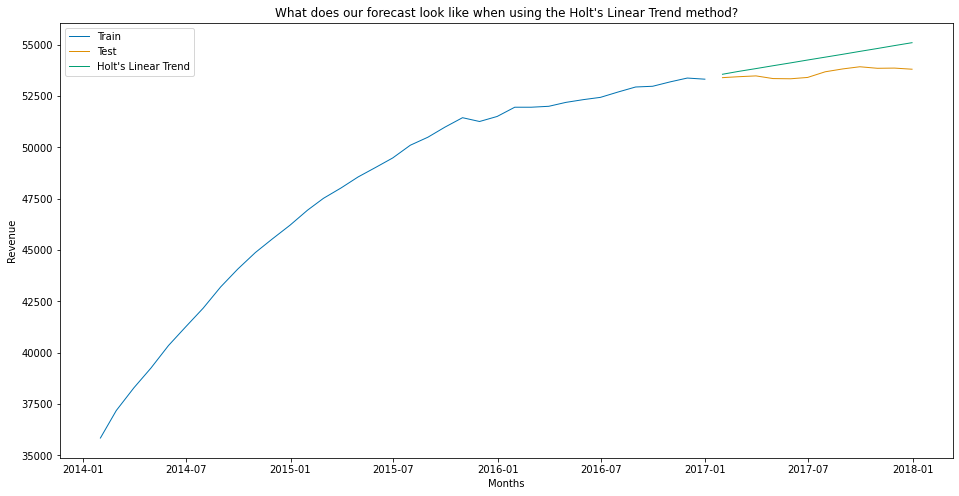

In [54]:
plot_and_eval(model="Holt's Linear Trend")

### Append Evaluation Metrics

In [55]:
eval_df = append_eval_df(model_type="Holt's Linear Trend")
eval_df

,model_type,target_var,rmse
0,Last Observed Value,amount,366.0
1,Simple Average,amount,5700.0
2,6M Moving Average,amount,574.0
3,3M moving average,amount,386.0
4,9M moving average,amount,816.0
5,12M moving average,amount,1024.0
6,24M moving average,amount,2509.0
7,Holt's Linear Trend,amount,780.0


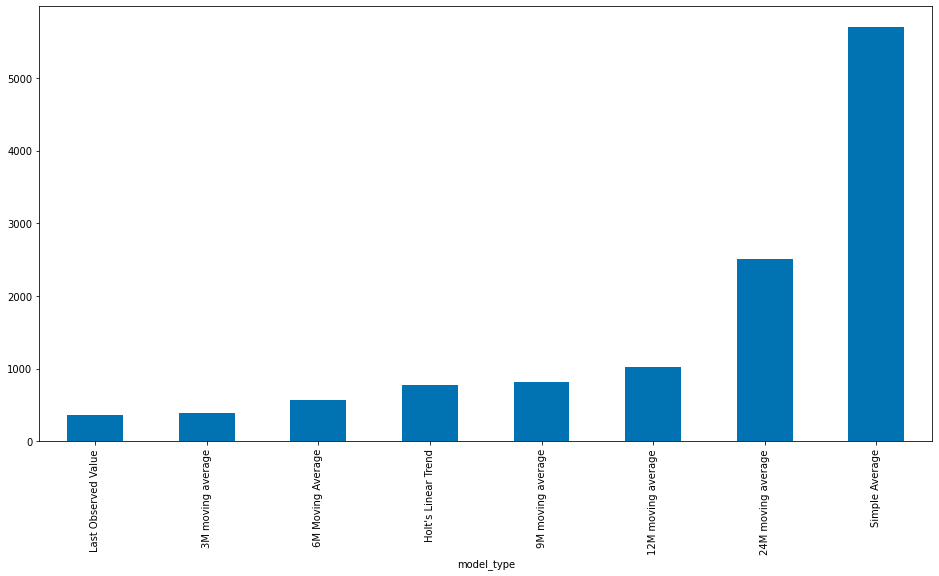

In [56]:
eval_df.set_index("model_type").rmse.sort_values().plot.bar()
plt.show()

## Previous Cycle
### Predict

In [57]:
train

,amount
invoice_month,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [58]:
yhat_df = train["2016"] + train.diff(12).mean()
yhat_df.index = pd.date_range("2017-01-01", periods=len(yhat_df), freq="M")
yhat_df

,amount
2017-01-31,57499.375
2017-02-28,57499.375
2017-03-31,57544.375
2017-04-30,57734.375
2017-05-31,57869.375
2017-06-30,57979.375
2017-07-31,58239.375
2017-08-31,58484.375
2017-09-30,58519.375
2017-10-31,58734.375


In [59]:
print(yhat_df.head(1))
print(test.head(1))

               amount
2017-01-31  57499.375
                amount
invoice_month         
2017-01-31     53395.0


In [60]:
print(len(yhat_df))
print(len(test))

12
12


### Evaluate

In [61]:
print(f"Previous Year = {evaluate()}")

Previous Year = 4557.0


### Plot Actual vs. Predicted Values

amount rmse = 4557.0


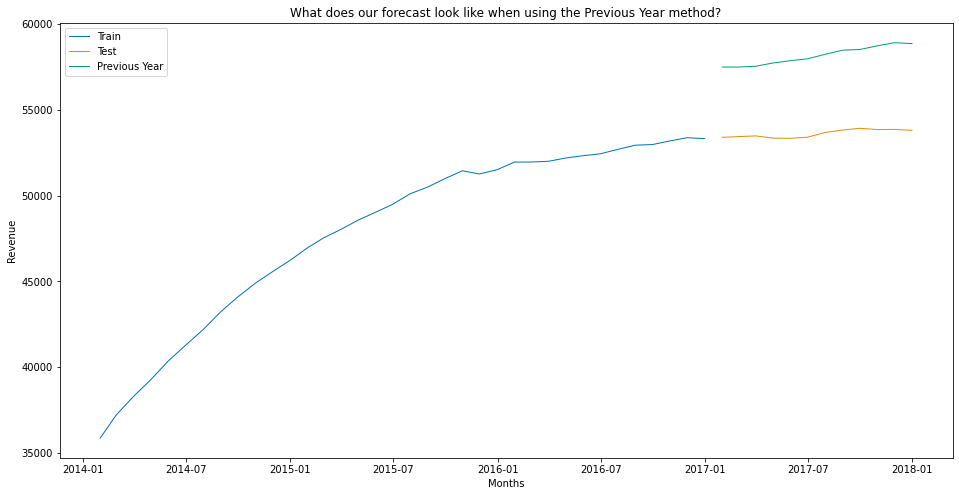

In [62]:
plot_and_eval(model="Previous Year")

### Append Evaluation Metrics

In [63]:
eval_df = append_eval_df(model_type="Previous Year")
eval_df

,model_type,target_var,rmse
0,Last Observed Value,amount,366.0
1,Simple Average,amount,5700.0
2,6M Moving Average,amount,574.0
3,3M moving average,amount,386.0
4,9M moving average,amount,816.0
5,12M moving average,amount,1024.0
6,24M moving average,amount,2509.0
7,Holt's Linear Trend,amount,780.0
8,Previous Year,amount,4557.0


## Facebook Prophet
### Prepare

In [64]:
df = wr.wrangle_saas_data()
print(f"The saas DataFrame is made up of {df.shape[0]:,} rows {df.shape[1]} columns.")
df

The saas DataFrame is made up of 790,458 rows 4 columns.


,customer_id,invoice_id,subscription_type,amount
invoice_month,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0
2014-01-31,1013334,5013334,0.0,0.0
2014-01-31,1013333,5013333,1.0,5.0
...,...,...,...,...
2017-12-31,1012069,5781185,0.0,0.0
2017-12-31,1012072,5781186,0.0,0.0
2017-12-31,1012074,5781187,1.0,5.0


In [65]:
df = pd.DataFrame(df.resample("M").amount.sum()).reset_index()
df

,invoice_month,amount
0,2014-01-31,35850.0
1,2014-02-28,37190.0
2,2014-03-31,38295.0
3,2014-04-30,39255.0
4,2014-05-31,40355.0
5,2014-06-30,41255.0
6,2014-07-31,42170.0
7,2014-08-31,43210.0
8,2014-09-30,44075.0
9,2014-10-31,44880.0


In [66]:
def prep_data(df):
    return df.\
            assign(ds=pd.to_datetime(df.invoice_month)).\
            sort_values('ds').\
            assign(y=df.amount).\
            groupby(['ds'])['y'].sum().\
            reset_index().\
            set_index('ds')

In [67]:
df = prep_data(df)
df

,y
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


### Predict